In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import statsmodels.api as sm


# Modeling + evaluation
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor


# Linear models
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Tree/ensemble models
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, StackingRegressor

# Curve fitting
from scipy.optimize import curve_fit


In [95]:
master_df = pd.read_csv("../CLEANING_SCRIPTS/master_df.csv")
display(master_df.head())

,county,Case_Fatality_Ratio,final_full,final_elderly,final_booster,final_elderly_booster,avg_full,obesity_pct,diabetes_deaths,smoking_pct,sedentary_pct,poverty_pct,hospital_beds,overweight_pct,pct_65plus,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,EP_POV150,EP_UNEMP,EP_HBURD,EP_NOHSDP,EP_UNINSUR,EP_AGE65,EP_AGE17,EP_DISABL,EP_SNGPNT,EP_LIMENG,EP_MINRTY,EP_AFAM,EP_HISP,EP_ASIAN,EP_AIAN,EP_NHPI,EP_TWOMORE,EP_OTHERRACE,EP_MUNIT,EP_MOBILE,EP_CROWD,EP_NOVEH,EP_GROUPQ
0,Alachua,0.878739,0.678,0.950,0.478,0.695,0.472043,0.298,0.237,0.114,0.218,0.201,0.892041,0.275,0.151535,0.3788,0.0000,0.7273,0.7424,0.2879,0.284,0.051,0.326,0.064,0.079,0.147,0.177,0.115,0.052,0.011,0.404,0.191,0.109,0.059,0.002,0.001,0.038,0.005,0.204,0.066,0.020,0.071,0.066
1,Baker,1.468813,0.371,0.748,0.308,0.542,0.236766,0.364,0.253,0.297,0.349,0.117,1.296488,0.343,0.146440,0.2727,0.2576,0.1667,0.3485,0.2273,0.215,0.049,0.205,0.149,0.113,0.149,0.235,0.154,0.071,0.003,0.219,0.115,0.032,0.007,0.002,0.000,0.063,0.000,0.006,0.348,0.022,0.040,0.106
2,Bay,1.598526,0.542,0.813,0.358,0.594,0.352284,0.299,0.299,0.221,0.297,0.129,0.679911,0.364,0.188792,0.4545,0.8030,0.2879,0.4242,0.4545,0.209,0.040,0.295,0.096,0.137,0.181,0.208,0.195,0.067,0.018,0.250,0.102,0.072,0.020,0.002,0.001,0.046,0.007,0.209,0.118,0.028,0.040,0.015
3,Bradford,1.926404,0.462,0.769,0.333,0.616,0.290032,0.358,0.286,0.271,0.358,0.194,-0.886734,0.304,0.183389,0.8485,0.4242,0.3636,0.9394,0.7273,0.284,0.058,0.284,0.179,0.109,0.178,0.197,0.181,0.079,0.001,0.274,0.173,0.047,0.009,0.001,0.000,0.044,0.000,0.049,0.295,0.020,0.070,0.135
4,Brevard,1.400125,0.660,0.908,0.449,0.637,0.446101,0.307,0.201,0.163,0.279,0.106,0.541401,0.366,0.244623,0.1667,0.1515,0.4242,0.1515,0.1364,0.180,0.049,0.263,0.073,0.100,0.240,0.181,0.163,0.044,0.013,0.280,0.092,0.114,0.023,0.001,0.001,0.042,0.007,0.128,0.072,0.015,0.047,0.012


In [96]:
from sklearn.linear_model import Ridge, ElasticNet

def run_baseline_linear(master_df, target_col="Case_Fatality_Ratio", random_state=42):
    df = master_df.dropna(subset=[target_col]).select_dtypes(include=[np.number]).copy()
    X = df.drop(columns=[target_col])
    y = df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    def adjusted_r2(r2, n, p):
        if n - p - 1 <= 0:
            return np.nan
        return 1 - (1 - r2) * (n - 1) / (n - p - 1)

    results = {}

    # Ridge
    ridge = Ridge()
    ridge_grid = GridSearchCV(ridge, {"alpha": np.logspace(-2,2,30)}, cv=5, scoring="r2")
    ridge_grid.fit(X_train, y_train)
    best_ridge = ridge_grid.best_estimator_
    results["Ridge"] = {
        "Test R²": best_ridge.score(X_test, y_test),
        "Adj R²": adjusted_r2(best_ridge.score(X_train, y_train), X_train.shape[0], X_train.shape[1]),
        "CV R²": cross_val_score(best_ridge, X, y, cv=5, scoring="r2").mean()
    }

    # ElasticNet
    enet = ElasticNet(max_iter=10000)
    enet_grid = GridSearchCV(enet, {"alpha": np.logspace(-3,1,20), "l1_ratio": np.linspace(0.1,0.9,9)}, cv=5, scoring="r2")
    enet_grid.fit(X_train, y_train)
    best_enet = enet_grid.best_estimator_
    results["ElasticNet"] = {
        "Test R²": best_enet.score(X_test, y_test),
        "Adj R²": adjusted_r2(best_enet.score(X_train, y_train), X_train.shape[0], X_train.shape[1]),
        "CV R²": cross_val_score(best_enet, X, y, cv=5, scoring="r2").mean()
    }

    for model, res in results.items():
        print(f"\n--- {model} ---")
        print(f"Test R²: {res['Test R²']:.4f}")
        print(f"Adjusted R² (train): {res['Adj R²']:.4f}")
        print(f"Mean CV R²: {res['CV R²']:.4f}")
    return results

baseline_results = run_baseline_linear(master_df, target_col="Case_Fatality_Ratio")




--- Ridge ---
Test R²: 0.4998
Adjusted R² (train): -0.5265
Mean CV R²: 0.4553

--- ElasticNet ---
Test R²: 0.4938
Adjusted R² (train): -0.5988
Mean CV R²: 0.4501


In [97]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

def run_pca_ridge(master_df, target_col="Case_Fatality_Ratio", random_state=42):
    df = master_df.dropna(subset=[target_col]).select_dtypes(include=[np.number]).copy()
    X = df.drop(columns=[target_col])
    y = df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    def adjusted_r2(r2, n, p):
        if n - p - 1 <= 0:
            return np.nan
        return 1 - (1 - r2) * (n - 1) / (n - p - 1)

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=20)),
        ("ridge", Ridge())
    ])

    param_grid = {"ridge__alpha": np.logspace(-2, 2, 30)}
    grid = GridSearchCV(pipe, param_grid, cv=5, scoring="r2")
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_

    r2_test = best_model.score(X_test, y_test)
    r2_train = best_model.score(X_train, y_train)
    adj_r2 = adjusted_r2(r2_train, X_train.shape[0], 20)  # 20 PCs
    cv_r2 = cross_val_score(best_model, X, y, cv=5, scoring="r2").mean()

    print("\n--- PCA + Ridge ---")
    print(f"Test R²: {r2_test:.4f}")
    print(f"Adjusted R² (train): {adj_r2:.4f}")
    print(f"Mean CV R²: {cv_r2:.4f}")
    print("Explained variance by 20 PCs:", best_model.named_steps["pca"].explained_variance_ratio_.sum())
    return best_model

pca_ridge_model = run_pca_ridge(master_df, target_col="Case_Fatality_Ratio")



--- PCA + Ridge ---
Test R²: 0.6442
Adjusted R² (train): 0.5262
Mean CV R²: 0.5043
Explained variance by 20 PCs: 0.9786322393975687


In [76]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

def run_elasticnet_ridge_hybrid(master_df, target_col="Case_Fatality_Ratio", random_state=42):
    """
    Step 1: Use ElasticNet to select features
    Step 2: Refit Ridge regression on those features to balance R² and Adjusted R²
    """

    # ✅ Numeric only
    df = master_df.dropna(subset=[target_col]).select_dtypes(include=[np.number]).copy()
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_state
    )

    # --- Step 1: ElasticNet Feature Selection ---
    enet_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", ElasticNet(max_iter=10000))
    ])

    enet_params = {
        "model__alpha": np.logspace(-3, 1, 30),
        "model__l1_ratio": np.linspace(0.1, 0.9, 9)
    }
    enet_grid = GridSearchCV(enet_pipe, enet_params, cv=5, scoring="r2")
    enet_grid.fit(X_train, y_train)
    best_enet = enet_grid.best_estimator_

    # Select nonzero features
    coefs = best_enet.named_steps["model"].coef_
    selected_features = X.columns[coefs != 0]

    print(f"Selected features ({len(selected_features)}): {list(selected_features)}")

    # --- Step 2: Ridge Refit ---
    ridge_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", Ridge())
    ])

    ridge_params = {"model__alpha": np.logspace(-2, 2, 30)}
    ridge_grid = GridSearchCV(ridge_pipe, ridge_params, cv=5, scoring="r2")
    ridge_grid.fit(X_train[selected_features], y_train)
    best_ridge = ridge_grid.best_estimator_

    # Evaluate
    r2_train = best_ridge.score(X_train[selected_features], y_train)
    r2_test = best_ridge.score(X_test[selected_features], y_test)
    cv_r2 = cross_val_score(best_ridge, X[selected_features], y, cv=5, scoring="r2").mean()

    # Adjusted R² (training)
    def adjusted_r2(r2, n, p):
        if n - p - 1 <= 0:
            return np.nan
        return 1 - (1 - r2) * (n - 1) / (n - p - 1)
    adj_r2 = adjusted_r2(r2_train, X_train.shape[0], len(selected_features))

    print("\n--- ElasticNet + Ridge Hybrid ---")
    print(f"Test R²: {r2_test:.4f}")
    print(f"Adjusted R² (train): {adj_r2:.4f}")
    print(f"Mean CV R²: {cv_r2:.4f}")
    print(f"Best Ridge alpha: {ridge_grid.best_params_['model__alpha']:.4f}")

    return best_ridge, selected_features
hybrid_model, hybrid_features = run_elasticnet_ridge_hybrid(master_df, target_col="Case_Fatality_Ratio")


Selected features (20): ['final_full', 'final_elderly', 'avg_full', 'diabetes_deaths', 'smoking_pct', 'sedentary_pct', 'hospital_beds', 'pct_65plus', 'RPL_THEME2', 'RPL_THEME3', 'EP_HBURD', 'EP_AGE65', 'EP_DISABL', 'EP_SNGPNT', 'EP_MINRTY', 'EP_NHPI', 'EP_TWOMORE', 'EP_OTHERRACE', 'EP_MUNIT', 'EP_MOBILE']

--- ElasticNet + Ridge Hybrid ---
Test R²: 0.6678
Adjusted R² (train): 0.5484
Mean CV R²: 0.5925
Best Ridge alpha: 28.0722


In [92]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline

def optimize_svr(master_df, target_col="Case_Fatality_Ratio", random_state=42):
    """
    Refines SVR hyperparameters around the best region found earlier.
    Reports Test R², Adjusted R², and CV R².
    """

    # ✅ Keep only numeric features
    df = master_df.dropna(subset=[target_col]).select_dtypes(include=[np.number]).copy()
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_state
    )

    # Adjusted R² helper
    def adjusted_r2(r2, n, p):
        if n - p - 1 <= 0:
            return np.nan
        return 1 - (1 - r2) * (n - 1) / (n - p - 1)

    # --- Refined SVR Search ---
    svr_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("svr", SVR(kernel="rbf"))
    ])

    svr_params = {
        "svr__C": np.linspace(3, 15, 7),        # around 5–15
        "svr__gamma": [0.005, 0.008, 0.01, 0.015, 0.02],  # zoom in near 0.01
        "svr__epsilon": [0.15, 0.18, 0.2, 0.22, 0.25]     # near 0.2
    }

    svr_grid = GridSearchCV(svr_pipe, svr_params, cv=5, scoring="r2", n_jobs=-1)
    svr_grid.fit(X_train, y_train)
    best_svr = svr_grid.best_estimator_

    # Evaluate
    r2_test = best_svr.score(X_test, y_test)
    r2_train = best_svr.score(X_train, y_train)
    adj_r2 = adjusted_r2(r2_train, X_train.shape[0], X_train.shape[1])
    cv_r2 = cross_val_score(best_svr, X, y, cv=5, scoring="r2").mean()

    print("\n--- Optimized SVR ---")
    print(f"Test R²: {r2_test:.4f}")
    print(f"Adjusted R² (train): {adj_r2:.4f}")
    print(f"Mean CV R²: {cv_r2:.4f}")
    print(f"Best Params: {svr_grid.best_params_}")

    return best_svr, svr_grid.best_params_

best_svr_model, best_svr_params = optimize_svr(master_df, target_col="Case_Fatality_Ratio")




--- Optimized SVR ---
Test R²: 0.6684
Adjusted R² (train): 0.4982
Mean CV R²: 0.5643
Best Params: {'svr__C': 5.0, 'svr__epsilon': 0.18, 'svr__gamma': 0.015}


In [91]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

def run_advanced_models(master_df, target_col="Case_Fatality_Ratio", random_state=42):
    """
    Trains improved Gradient Boosting, refined SVR, and a Stacking Ensemble with ElasticNet+SVR+GB.
    Reports R², Adjusted R², CV R².
    """

    # ✅ Numeric only
    df = master_df.dropna(subset=[target_col]).select_dtypes(include=[np.number]).copy()
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_state
    )

    # Adjusted R² helper
    def adjusted_r2(r2, n, p):
        if n - p - 1 <= 0:
            return np.nan
        return 1 - (1 - r2) * (n - 1) / (n - p - 1)

    results = {}

    # --- Improved Gradient Boosting ---
    gb = GradientBoostingRegressor(random_state=random_state)
    gb_params = {
        "n_estimators": [1000, 2000],
        "learning_rate": [0.01, 0.05],
        "max_depth": [2, 3],
        "subsample": [0.7, 0.85],
        "min_samples_leaf": [3, 5, 10]
    }
    gb_grid = GridSearchCV(gb, gb_params, cv=5, scoring="r2", n_jobs=-1)
    gb_grid.fit(X_train, y_train)
    best_gb = gb_grid.best_estimator_

    r2_test = best_gb.score(X_test, y_test)
    r2_train = best_gb.score(X_train, y_train)
    adj_r2 = adjusted_r2(r2_train, X_train.shape[0], X_train.shape[1])
    cv_r2 = cross_val_score(best_gb, X, y, cv=5, scoring="r2").mean()

    results["GradientBoosting"] = {
        "R²": r2_test,
        "Adj R²": adj_r2,
        "CV R²": cv_r2,
        "Best Params": gb_grid.best_params_
    }

    # --- Refined SVR ---
    svr_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("svr", SVR(kernel="rbf"))
    ])
    svr_params = {
        "svr__C": np.linspace(0.5, 5, 6),
        "svr__gamma": [0.005, 0.01, 0.05, 0.1],
        "svr__epsilon": [0.01, 0.05, 0.1, 0.2]
    }
    svr_grid = GridSearchCV(svr_pipe, svr_params, cv=5, scoring="r2", n_jobs=-1)
    svr_grid.fit(X_train, y_train)
    best_svr = svr_grid.best_estimator_

    r2_test = best_svr.score(X_test, y_test)
    r2_train = best_svr.score(X_train, y_train)
    adj_r2 = adjusted_r2(r2_train, X_train.shape[0], X_train.shape[1])
    cv_r2 = cross_val_score(best_svr, X, y, cv=5, scoring="r2").mean()

    results["SVR"] = {
        "R²": r2_test,
        "Adj R²": adj_r2,
        "CV R²": cv_r2,
        "Best Params": svr_grid.best_params_
    }

    # --- Stacking Ensemble (ElasticNet + SVR + GB) ---
    base_learners = [
        ("enet", ElasticNet(alpha=0.3, l1_ratio=0.1, max_iter=10000, random_state=random_state)),
        ("svr", best_svr),
        ("gb", best_gb)
    ]
    stack = StackingRegressor(
        estimators=base_learners,
        final_estimator=ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=10000, random_state=random_state),
        passthrough=True,
        n_jobs=-1
    )
    stack.fit(X_train, y_train)

    r2_test = stack.score(X_test, y_test)
    r2_train = stack.score(X_train, y_train)
    adj_r2 = adjusted_r2(r2_train, X_train.shape[0], X_train.shape[1])
    cv_r2 = cross_val_score(stack, X, y, cv=5, scoring="r2").mean()

    results["StackingEnsemble"] = {
        "R²": r2_test,
        "Adj R²": adj_r2,
        "CV R²": cv_r2
    }

    # --- Print results ---
    for model, res in results.items():
        print(f"\n--- {model} ---")
        print(f"Test R²: {res['R²']:.4f}")
        print(f"Adjusted R² (train): {res['Adj R²']:.4f}")
        print(f"Mean CV R²: {res['CV R²']:.4f}")
        if "Best Params" in res:
            print(f"Best Params: {res['Best Params']}")

    return results
results_advanced = run_advanced_models(master_df, target_col="Case_Fatality_Ratio")



--- GradientBoosting ---
Test R²: 0.5849
Adjusted R² (train): 0.9742
Mean CV R²: 0.4247
Best Params: {'learning_rate': 0.01, 'max_depth': 2, 'min_samples_leaf': 3, 'n_estimators': 1000, 'subsample': 0.85}

--- SVR ---
Test R²: 0.7071
Adjusted R² (train): 0.4087
Mean CV R²: 0.5981
Best Params: {'svr__C': 5.0, 'svr__epsilon': 0.2, 'svr__gamma': 0.01}

--- StackingEnsemble ---
Test R²: 0.5377
Adjusted R² (train): -0.5594
Mean CV R²: 0.3797


In [ ]:
#!pip install xgboost
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import r2_score
from xgboost import XGBRegressor, plot_importance
import matplotlib.pyplot as plt

def run_xgboost(master_df, target_col="Case_Fatality_Ratio", random_state=42):
    """
    Train and tune an XGBoost Regressor for CFR prediction.
    Reports Test R², Adjusted R², and CV R².
    """

    # ✅ Numeric only
    df = master_df.dropna(subset=[target_col]).select_dtypes(include=[np.number]).copy()
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_state
    )

    # Adjusted R² helper
    def adjusted_r2(r2, n, p):
        if n - p - 1 <= 0:
            return np.nan
        return 1 - (1 - r2) * (n - 1) / (n - p - 1)

    # --- XGBoost with GridSearch ---
    xgb = XGBRegressor(objective="reg:squarederror", random_state=random_state)

    param_grid = {
        "n_estimators": [500, 1000],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [2, 3, 5],
        "subsample": [0.7, 0.9, 1.0],
        "colsample_bytree": [0.7, 0.9, 1.0],
        "reg_alpha": [0, 0.1, 1],  # L1
        "reg_lambda": [1, 5, 10],  # L2
    }

    xgb_grid = GridSearchCV(xgb, param_grid, cv=5, scoring="r2", n_jobs=-1, verbose=1)
    xgb_grid.fit(X_train, y_train)
    best_xgb = xgb_grid.best_estimator_

    # --- Evaluation ---
    r2_test = best_xgb.score(X_test, y_test)
    r2_train = best_xgb.score(X_train, y_train)
    adj_r2 = adjusted_r2(r2_train, X_train.shape[0], X_train.shape[1])
    cv_r2 = cross_val_score(best_xgb, X, y, cv=5, scoring="r2").mean()

    print("\n--- XGBoost ---")
    print(f"Test R²: {r2_test:.4f}")
    print(f"Adjusted R² (train): {adj_r2:.4f}")
    print(f"Mean CV R²: {cv_r2:.4f}")
    print(f"Best Params: {xgb_grid.best_params_}")

    # --- Feature Importances ---
    plt.figure(figsize=(10,6))
    plot_importance(best_xgb, importance_type="gain", max_num_features=15)
    plt.title("Top Feature Importances (XGBoost)")
    plt.show()

    return best_xgb, xgb_grid.best_params_


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 5.5 MB/s  0:00:00m 5.5 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 5.5 MB/s  0:00:01a 0:00:01m eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:━━━━━━━━━━━━━━━━━━━━━━━━ 0/2 [numpy]
      Successfully uninstalled numpy-1.21.6━━━━━━━━━━━ 0/2 [numpy]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [xgboost]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
astropy 5.3.4 requires numpy<2,>=1.21, but you have numpy 2.0.2 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.0.2 which is incompatible.
matplotlib 3.7.5 requires numpy<2,>=1.20, but you have numpy 2.0.2 which is incompatible.
pycaret 3.3.2 requires imbalanced-learn>=0.12.0, but you have imbalanced-learn 0.10.1 which is incom

Fitting 5 folds for each of 1458 candidates, totalling 7290 fits

--- XGBoost ---
Test R²: 0.4863
Adjusted R² (train): 0.9142
Mean CV R²: 0.3709
Best Params: {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.9}


<Figure size 1000x600 with 0 Axes>

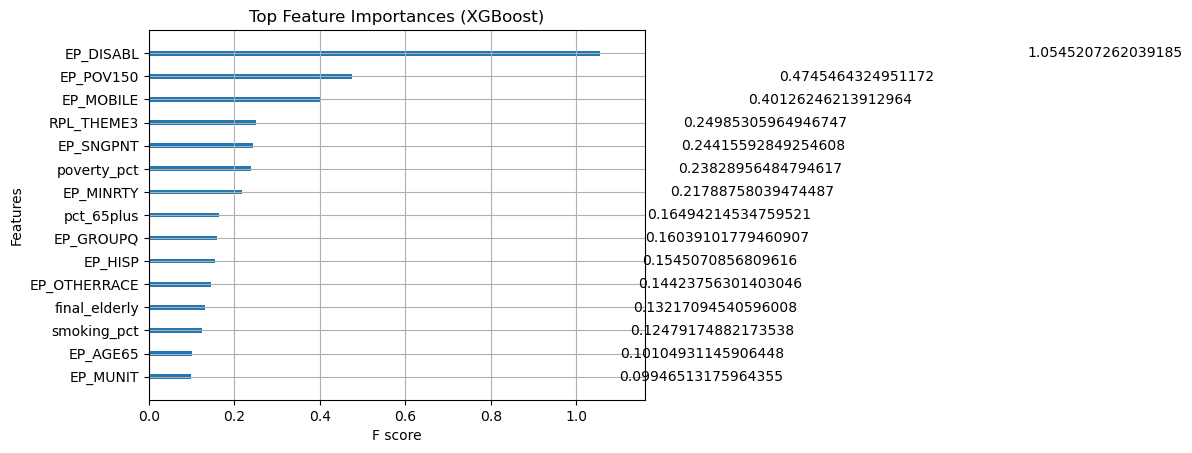

In [94]:
best_xgb_model, best_xgb_params = run_xgboost(master_df, target_col="Case_Fatality_Ratio")
